# Setup

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/NLP_09 Speech Recognition 

/content/drive/.shortcut-targets-by-id/17BjSxi0IUoqSovHTE1jPK8ZepBsdHMDf/NLP_09 Speech Recognition


In [ ]:
!ls

 dataset	    demo_audio.wav
 dataset_attr.csv   model.json
 demo_audio2.wav   'NLP_09 Speech Emotion Recognition (SER).ipynb'
 demo_audio4.wav   'NLP_09 SR_STT_TTS.ipynb'
 demo_audio5.wav    Trained_Models


In [ ]:
# Provides a way of using operating system dependent functionality. 
import os

# LibROSA provides the audio analysis
import librosa
# Need to implictly import from librosa
import librosa.display

# Import the audio playback widget
import IPython.display as ipd
from IPython.display import Image

In [ ]:
import matplotlib.pyplot as plt

# Enable plot in the notebook
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# These are generally useful to have around
import numpy as np
import pandas as pd

# To build Neural Network and Create desired Model
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D #, AveragePooling1D
from keras.layers import Flatten, Dropout, Activation # Input, 
from keras.layers import Dense #, Embedding
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

# Data Preparation
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

In [ ]:
data, sampling_rate = librosa.load('dataset/disgust/disgust016.wav')

# To play audio this in the jupyter notebook
ipd.Audio('dataset/disgust/disgust016.wav')

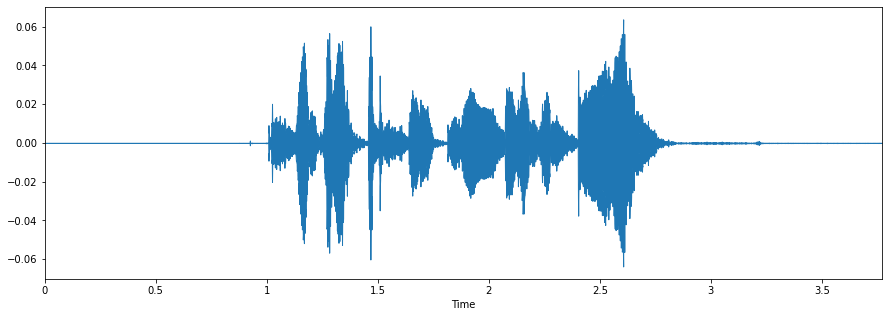

In [ ]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)
plt.show()

## Setup Basic Parameter

In [ ]:
dataset_path = os.path.abspath('./dataset')
destination_path = os.path.abspath('./')

# To shuffle the dataset instances/records
randomize = True
# for spliting dataset into training and testing dataset
split = 0.8
# Number of sample per second e.g. 16KHz
sampling_rate = 20000 
emotions = ['anger','disgust','fear','happy','neutral','sad','surprise']

## Converting Dataset in CSV Format

In [ ]:
import sys
import csv

def create_meta_csv(dataset_path, destination_path):
    """Create a meta csv file given a dataset folder path of Audio.
    
    This function creates and saves a meta csv file named 'dataset_attr.csv' given a dataset folder path of audios.
    The file will contain audios and their labels. This file can be then used to make
    train, test and val splits, randomize them and load few of them (a mini-batch) in memory
    as required. The file is saved in dataset_path folder if destination_path is not provided.
    
    Args:
        dataset_path (str): Path to dataset folder
        destination_path (str): Destination to store meta file if None provided, it'll store file in dataset_path
    Returns:
        True (bool): Returns True if 'dataset_attr.csv' was created successfully else returns an exception
    """
    # Change dataset path accordingly
    DATASET_PATH = os.path.abspath(dataset_path)
    csv_path=os.path.join(destination_path, 'dataset_attr.csv')
    flist = []
    emotions = ['anger','disgust','fear','happy','neutral','sad','surprise']
    for root, dirs, files in os.walk(DATASET_PATH, topdown=False):
        for name in files:
            if (name.endswith('.wav')): 
                fullName = os.path.join(root, name)
                flist.append(fullName)

    split_format = str('/') if sys.platform=='linux' else str('\\')
    
    filenames=[]
    for idx,file in enumerate(flist):
        filenames.append(file.split(split_format)) 
        # print(filenames[idx])
    types=[]
    for idx,path in enumerate(filenames):
        types.append((flist[idx],emotions.index(path[-2]))) ##second last location has emotion name

    with open(csv_path, 'w') as f:
        writer = csv.writer(f)
        writer.writerows([("path","label")])
        writer.writerows(types)
    f.close()
    # change destination_path to DATASET_PATH if destination_path is None 
    if destination_path == None:
        destination_path = DATASET_PATH
        # write out as dataset_attr.csv in destination_path directory
        # if no error
    return True
    
def create_and_load_meta_csv_df(dataset_path, destination_path, randomize=True, split=None):
    """Create a meta csv file given a dataset folder path of audios and loads it as a pandas dataframe.
    This function creates and saves a meta csv file named 'dataset_attr.csv' given a dataset folder path of audios.
    The function will return pandas dataframes for the csv and also train and test splits if you specify a 
    fraction in split parameter.
    
    Args:
        dataset_path (str): Path to dataset folder
        destination_path (str): Destination to store meta csv file
        randomize (bool, optional): Randomize the csv records. Defaults to True
        split (double, optional): Percentage of train records. Defaults to None
    Returns:
        dframe (pandas.Dataframe): Returns a single Dataframe for csv if split is none, else returns more two Dataframes for train and test splits.
        train_set (pandas.Dataframe): Returns a Dataframe of length (split) * len(dframe)
        test_set (pandas.Dataframe): Returns a Dataframe of length (1 - split) * len(dframe)
    """
    if create_meta_csv(dataset_path, destination_path=destination_path):
        dframe = pd.read_csv(os.path.join(destination_path, 'dataset_attr.csv'))

    # shuffle if randomize is True or if split specified and randomize is not specified 
    # so default behavior is split
    if randomize == True or (split != None and randomize == None):
        # shuffle the dataframe here
        dframe=dframe.sample(frac=1).reset_index(drop=True)
        pass

    if split != None:
        train_set, test_set = train_test_split(dframe, split)
        return dframe, train_set, test_set 
    
    return dframe

def train_test_split(dframe, split_ratio):
    """Splits the dataframe into train and test subset dataframes.
    Args:
        split_ration (float): Divides dframe into two splits.
    Returns:
        train_data (pandas.Dataframe): Returns a Dataframe of length (split_ratio) * len(dframe)
        test_data (pandas.Dataframe): Returns a Dataframe of length (1 - split_ratio) * len(dframe)
    """
    # divide into train and test dataframes
    train_data = dframe.iloc[:int((split_ratio) * len(dframe)), :]
    test_data = dframe.iloc[int((split_ratio) * len(dframe)):,:]
    test_data = test_data.reset_index(drop=True) #reset index for test data
    return train_data, test_data

In [ ]:
df, train_df, test_df = create_and_load_meta_csv_df(dataset_path, destination_path, randomize, split)

In [ ]:
print('Dataset samples  : ', len(df),"\nTraining Samples : ", len(train_df),"\nTesting Samples  : ", len(test_df))

Dataset samples  :  2556 
Training Samples :  2044 
testing Samples  :  512


## Data Visualization

In [ ]:
df.head()

,path,label
0,/content/drive/.shortcut-targets-by-id/17BjSxi...,2
1,/content/drive/.shortcut-targets-by-id/17BjSxi...,3
2,/content/drive/.shortcut-targets-by-id/17BjSxi...,6
3,/content/drive/.shortcut-targets-by-id/17BjSxi...,5
4,/content/drive/.shortcut-targets-by-id/17BjSxi...,0


In [ ]:
print("Actual Audio : ", df['path'][0])
print("Labels       : ", df['label'][0])

Actual Audio :  /content/drive/.shortcut-targets-by-id/17BjSxi0IUoqSovHTE1jPK8ZepBsdHMDf/NLP_09 Speech Recognition/dataset/fear/fear177.wav
Labels       :  2


Labels Assigned for emotions<br>
0 : anger
1 : disgust
2 : fear
3 : happy
4 : neutral
5 : sad
6 : surprise

In [ ]:
unique_labels = train_df.label.unique()
unique_labels.sort()

print("Unique labels in Emotion dataset : ")
print(*unique_labels, sep=', ')

unique_labels_counts = train_df.label.value_counts(sort=False)
print("\n\nCount of unique labels in Emotion dataset : ")
print(*unique_labels_counts,sep=', ')

Unique labels in Emotion dataset : 
0, 1, 2, 3, 4, 5, 6


Count of unique labels in Emotion dataset : 
339, 348, 208, 342, 354, 200, 253


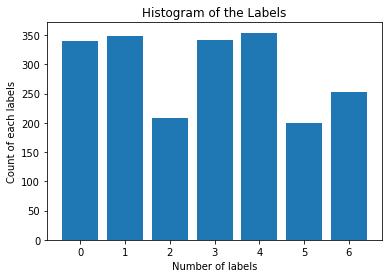

In [ ]:
# Histogram of the classes
plt.bar(unique_labels, unique_labels_counts, align='center')
plt.xlabel('Number of labels')
plt.xticks(unique_labels)
plt.ylabel('Count of each labels')
plt.title('Histogram of the Labels')
plt.show()

# Data Preprocessing
Getting the features of audio files using Librosa

In [ ]:
def get_audio_features(audio_path, sampling_rate):
    X, sample_rate = librosa.load(audio_path ,res_type='kaiser_fast', duration=2.5, sr=sampling_rate*2, offset=0.5)
    sample_rate = np.array(sample_rate)

    y_harmonic, y_percussive = librosa.effects.hpss(X)
    pitches, magnitudes = librosa.core.pitch.piptrack(y=X, sr=sample_rate)

    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=1)
    pitches = np.trim_zeros(np.mean(pitches, axis=1))[:20]
    magnitudes = np.trim_zeros(np.mean(magnitudes, axis=1))[:20]
    C = np.mean(librosa.feature.chroma_cqt(y=y_harmonic, sr=sampling_rate), axis=1)
    
    return [mfccs, pitches, magnitudes, C]
    
    
def get_features_dataframe(dataframe, sampling_rate):
    labels = pd.DataFrame(dataframe['label'])
    
    features  = pd.DataFrame(columns=['mfcc','pitches','magnitudes','C'])
    for index, audio_path in enumerate(dataframe['path']):
        features.loc[index] = get_audio_features(audio_path, sampling_rate)
    
    mfcc = features.mfcc.apply(pd.Series)
    pit = features.pitches.apply(pd.Series)
    mag = features.magnitudes.apply(pd.Series)
    C = features.C.apply(pd.Series)
    
    combined_features = pd.concat([mfcc, pit, mag,C], axis=1, ignore_index=True)

    return combined_features, labels

In [ ]:
trainfeatures, trainlabel = get_features_dataframe(train_df, sampling_rate)
testfeatures, testlabel = get_features_dataframe(test_df, sampling_rate)

In [ ]:
trainfeatures

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,-381.196259,69.728462,-38.960667,9.562358,2.976633,-10.908823,-30.545166,-1.581820,-27.965990,-17.162155,...,0.230351,0.264976,0.364963,0.670393,0.436854,0.284220,0.316513,0.307271,0.194668,0.213921
1,-313.584534,66.920967,-49.026657,-2.537738,-13.372161,-19.558279,-28.407242,5.366240,-23.275457,-6.681431,...,0.369169,0.362318,0.350101,0.439127,0.334401,0.431304,0.431890,0.379827,0.446960,0.640230
2,-328.191040,80.632591,-29.809317,7.035088,-16.120909,7.928294,-14.229992,-4.758874,-25.413425,-0.760995,...,0.488359,0.367501,0.332848,0.334186,0.259941,0.271841,0.331273,0.372467,0.537157,0.520731
3,-632.438110,80.438797,4.067166,17.866470,4.525138,15.420203,-4.755193,1.772279,-5.143723,-0.731769,...,0.637450,0.439755,0.318953,0.360493,0.428513,0.260900,0.229123,0.286548,0.346669,0.309741
4,-316.967285,67.124161,-39.501556,14.700308,-10.934939,7.269600,-21.668831,-0.564169,-18.213398,-5.065998,...,0.508187,0.379563,0.342941,0.326480,0.257361,0.250383,0.367650,0.451653,0.467677,0.401883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2039,-375.043121,68.773140,-32.539337,16.078894,-12.455579,6.434412,-12.277937,-8.615746,-20.402166,-2.621042,...,0.363859,0.252919,0.219634,0.241548,0.278791,0.295804,0.297190,0.313031,0.378405,0.412768
2040,-386.361847,85.750626,-33.581734,24.156218,-0.208949,7.968383,-23.511806,2.380987,-11.622324,-8.347213,...,0.297806,0.373309,0.477242,0.591777,0.320701,0.245944,0.422280,0.327280,0.228553,0.258037
2041,-593.490051,94.570854,3.036610,17.932095,6.148175,12.299563,-19.304316,3.527487,-16.920712,0.204779,...,0.326923,0.392813,0.552841,0.433683,0.435634,0.425226,0.429172,0.382172,0.410123,0.291821
2042,-646.344604,104.700043,3.637932,7.794867,9.204741,21.814127,-10.338256,7.597030,-13.180010,-0.943901,...,0.309046,0.311881,0.345906,0.266431,0.195546,0.152697,0.203787,0.384405,0.581750,0.422877


In [ ]:
trainfeatures.shape

(2044, 65)

In [ ]:
# By using numpy ravel() : Converting 2D to 1D e.g. (512,1) -> (512,). To prevent DataConversionWarning

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel).ravel()
X_test = np.array(testfeatures)
y_test = np.array(testlabel).ravel()

In [ ]:
y_train[:5]

array([0, 0, 2, 2, 0])

In [ ]:
# One-Hot Encoding
lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [ ]:
y_train[:5]

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
X_train.shape

(2044, 65)

Changing dimension for CNN model

In [ ]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [ ]:
x_traincnn.shape

(2044, 65, 1)

# Model

In [ ]:
import tensorflow as tf

model = Sequential()

model.add(Conv1D(256, 5,padding='same', input_shape=(x_traincnn.shape[1],x_traincnn.shape[2])))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(y_train.shape[1]))
model.add(Activation('softmax'))

opt = tf.keras.optimizers.RMSprop(learning_rate=0.00001)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 65, 256)           1536      
                                                                 
 activation (Activation)     (None, 65, 256)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 65, 128)           163968    
                                                                 
 activation_1 (Activation)   (None, 65, 128)           0         
                                                                 
 dropout (Dropout)           (None, 65, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8, 128)           0         
 )                                                               
                                                        

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

# Training

In [ ]:
cnnhistory = model.fit(x_traincnn, y_train, batch_size=16, epochs=10, validation_data=(x_testcnn, y_test))

Epoch 1/10
128/128 [==============================] - 13s 8ms/step - loss: 2.0740 - accuracy: 0.1913 - val_loss: 1.8440 - val_accuracy: 0.2148
Epoch 2/10
128/128 [==============================] - 1s 6ms/step - loss: 1.8886 - accuracy: 0.2446 - val_loss: 1.7757 - val_accuracy: 0.2520
Epoch 3/10
128/128 [==============================] - 1s 5ms/step - loss: 1.8061 - accuracy: 0.2759 - val_loss: 1.7425 - val_accuracy: 0.2773
Epoch 4/10
128/128 [==============================] - 1s 6ms/step - loss: 1.7662 - accuracy: 0.2911 - val_loss: 1.6990 - val_accuracy: 0.3281
Epoch 5/10
128/128 [==============================] - 1s 5ms/step - loss: 1.7149 - accuracy: 0.3253 - val_loss: 1.6421 - val_accuracy: 0.3633
Epoch 6/10
128/128 [==============================] - 1s 5ms/step - loss: 1.6696 - accuracy: 0.3498 - val_loss: 1.6523 - val_accuracy: 0.3926
Epoch 7/10
128/128 [==============================] - 1s 6ms/step - loss: 1.6530 - accuracy: 0.3635 - val_loss: 1.6107 - val_accuracy: 0.3926
Epoch

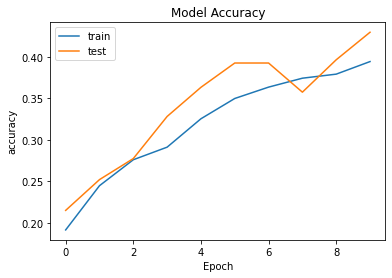

In [ ]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

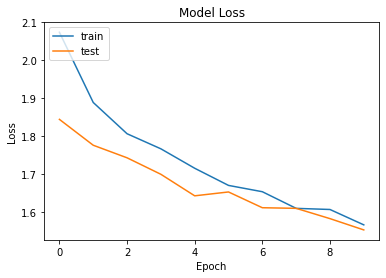

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Save the Model

In [ ]:
model_name = 'Speech_Emotion_Recognition_Model.h5'
save_dir = os.path.join(os.getcwd(), 'Trained_Models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/MyDrive/Orbit Future Academy/00_NLP Mastery/Hands-On/NLP_09 Speech Recognition/Trained_Models/Speech_Emotion_Recognition_Model.h5 


In [ ]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Load the Model

In [ ]:
# loading json and creating model
from keras.models import model_from_json

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("./Trained_Models/Speech_Emotion_Recognition_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 42.97%


# Model Evaluation

In [ ]:
preds = loaded_model.predict(x_testcnn, batch_size=32, verbose=1)

16/16 [==============================] - 0s 2ms/step


In [ ]:
preds

array([[0.36474973, 0.0540664 , 0.24497128, ..., 0.01864048, 0.09798212,
        0.01556841],
       [0.13514464, 0.13639645, 0.09577943, ..., 0.1636485 , 0.11532342,
        0.07579087],
       [0.1912948 , 0.0391346 , 0.2746754 , ..., 0.03191588, 0.16227038,
        0.01680422],
       ...,
       [0.12962589, 0.020142  , 0.26783067, ..., 0.04990883, 0.18951148,
        0.01550968],
       [0.20781536, 0.13908057, 0.12835312, ..., 0.05084328, 0.09233424,
        0.11628293],
       [0.17750455, 0.01692229, 0.22246432, ..., 0.10595796, 0.3989622 ,
        0.01268369]], dtype=float32)

In [ ]:
preds1 = preds.argmax(axis=1)

In [ ]:
preds1

array([0, 3, 3, 5, 0, 3, 3, 0, 5, 6, 4, 2, 3, 4, 6, 0, 5, 5, 4, 5, 3, 3,
       5, 1, 5, 4, 5, 0, 4, 2, 4, 6, 2, 1, 5, 5, 1, 3, 6, 4, 5, 1, 5, 1,
       1, 3, 5, 5, 1, 3, 5, 3, 6, 3, 6, 5, 0, 0, 6, 5, 3, 5, 2, 0, 3, 3,
       5, 3, 5, 2, 5, 3, 3, 5, 4, 4, 3, 4, 3, 0, 0, 4, 4, 5, 0, 5, 4, 6,
       5, 0, 3, 3, 5, 5, 0, 5, 5, 5, 3, 5, 2, 4, 5, 1, 0, 4, 5, 1, 4, 5,
       0, 1, 2, 4, 0, 0, 2, 0, 5, 5, 3, 3, 5, 0, 3, 5, 5, 2, 6, 3, 5, 5,
       1, 3, 0, 0, 4, 3, 6, 4, 5, 0, 1, 3, 0, 4, 2, 0, 4, 0, 1, 3, 0, 0,
       4, 0, 4, 0, 5, 1, 3, 4, 3, 0, 3, 0, 5, 1, 1, 2, 3, 6, 5, 0, 0, 1,
       0, 3, 6, 5, 1, 3, 2, 4, 3, 4, 5, 5, 1, 3, 0, 0, 5, 2, 0, 5, 5, 3,
       3, 0, 3, 0, 5, 5, 5, 0, 5, 5, 3, 5, 2, 5, 3, 4, 0, 1, 4, 5, 3, 4,
       5, 5, 4, 0, 0, 3, 5, 5, 5, 0, 0, 3, 5, 3, 0, 4, 5, 2, 0, 1, 5, 2,
       5, 2, 5, 3, 3, 4, 2, 3, 3, 6, 0, 3, 2, 5, 0, 5, 0, 5, 5, 3, 1, 2,
       3, 0, 5, 0, 5, 0, 3, 5, 1, 5, 1, 5, 3, 2, 5, 0, 0, 4, 3, 0, 4, 0,
       4, 4, 5, 3, 5, 3, 1, 6, 5, 2, 4, 0, 3, 4, 4,

In [ ]:
predictions = (lb.inverse_transform((preds1.astype(int).flatten())))

In [ ]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,0
1,3
2,3
3,5
4,0
5,3
6,3
7,0
8,5
9,6


In [ ]:
actual=y_test.argmax(axis=1)
actualvalues = (lb.inverse_transform((actual.astype(int).flatten())))

In [ ]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,3
1,3
2,5
3,0
4,6
5,0
6,3
7,0
8,4
9,5


In [ ]:
finaldf = actualdf.join(preddf)
finaldf

,actualvalues,predictedvalues
0,3,0
1,3,3
2,5,3
3,0,5
4,6,0
...,...,...
507,5,5
508,3,3
509,0,3
510,2,3


In [ ]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
0,90
1,54
2,91
3,79
4,58
5,82
6,58


In [ ]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
0,87
1,41
2,47
3,103
4,60
5,149
6,25


# Prediction

In [ ]:
demo_audio_path = './demo_audio.wav'

ipd.Audio('demo_audio.wav')

In [ ]:
demo_mfcc, demo_pitch, demo_mag, demo_chrom = get_audio_features(demo_audio_path, sampling_rate)

mfcc = pd.Series(demo_mfcc)
pit = pd.Series(demo_pitch)
mag = pd.Series(demo_mag)
C = pd.Series(demo_chrom)

demo_audio_features = pd.concat([mfcc,pit,mag,C],ignore_index=True)

In [ ]:
demo_audio_features

0    -454.475281
1      96.698708
2     -21.329622
3      19.815138
4       5.109882
         ...    
60      0.359009
61      0.350219
62      0.304260
63      0.285267
64      0.303017
Length: 65, dtype: float32

In [ ]:
demo_audio_features= np.expand_dims(demo_audio_features, axis=0)
demo_audio_features= np.expand_dims(demo_audio_features, axis=2)

In [ ]:
demo_audio_features.shape

(1, 65, 1)

In [ ]:
demo_preds = loaded_model.predict(demo_audio_features, batch_size=32, verbose=1)

1/1 [==============================] - 0s 126ms/step


In [ ]:
demo_preds

array([[0.29570562, 0.09955589, 0.22184946, 0.1835351 , 0.02189521,
        0.06185489, 0.11560384]], dtype=float32)

In [ ]:
index = demo_preds.argmax(axis=1).item()

index

0

In [ ]:
emotions[index]

'anger'